In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from wordcloud import WordCloud
from pingouin import cronbach_alpha

In [2]:
sns.set_style({'font.family':"sans-serif"})
sns.set_style('darkgrid')

**Methods and definitions.**

In [3]:
def my_pie(data, group, title, ax=None, figsize=None):
    data.groupby([group]).size().plot.pie(
        title=title, 
        ylabel='', 
        autopct=lambda p:'{:.1f}% ({:.0f})'.format(p, (p/100)*data.groupby([group]).size().sum()),
        figsize=figsize,
        ax=ax
    )

def my_bar(data, group, title, ax=None, figsize=None):
    ax_t = data.groupby([group]).size().plot.bar(
        title=title, 
        ylabel='count', 
        figsize=figsize,
        ax=ax
    )
    ax_t.bar_label(ax_t.containers[0])

def my_hist_with_qq(data, column, title, xlabel, figsize=(15, 6)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    data[column].plot.hist(title=title, ax=ax1)
    ax1.set_xlabel(xlabel)
    
    with mpl.rc_context():
        mpl.rc("figure", figsize=(3,3))
        sm.qqplot(data[column], line ='45', fit=True, ax=ax2)

def my_count(data, column, title, ax=None, order=None):
    fig, ax_t = plt.subplots()
    ax_t = sns.countplot(
        y = column, 
        data = data, 
        order = order, 
        ax=ax,
        palette='deep'
    )
    ax_t.bar_label(ax_t.containers[0])
    ax_t.set_title(title)

def my_box(data, columns, title, xlabel='count', ax=None, figsize=None):
    fig, ax_t = plt.subplots(figsize=figsize)
    ax_t = sns.boxplot(
        data=data[[x for x in data.columns if x in columns]],
        orient='h',
        ax=ax,
        palette='deep'
    ).set(xlabel=xlabel, title=title)

def my_box_xy(data, x, y, title, xlabel='count', ax=None, order=None):
    if(not ax):
        fig, ax_t = plt.subplots()
    sns.boxplot(
        data=data,
        orient='h',
        ax=ax,
        x=x,
        y=y,
        palette='deep',
        order=order
    ).set(xlabel=xlabel, title=title)
    
def my_dist(data, x, hue, title):
    sns.displot(
        data=data, 
        x=x, 
        hue=hue, 
        kind="kde",
    ).set(title=title)
    
def my_test(test, data, column, group, title):
    print(title)
    cols = [data[data[group] == x][column] for x in data[group].unique()]
    stat = test(*cols)
    print("{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))

    if(stat.pvalue < 0.05 and test == stats.kruskal):
        p_vals = []

        for comb in list(combinations(cols, 2)):
            stat = stats.mannwhitneyu(*comb)
            p_vals.append(stat.pvalue)

        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(data[group].unique(), 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')
        

def my_chi(data, group1, group2, merge_index=False, merge_cols=False):
    counts = data.groupby([group1, group2]).size().unstack().fillna(0)
    
    if(merge_index):
        for index in merge_index:
            for index2 in merge_index[index]:
                counts.loc[index] = counts.loc[index] + counts.loc[index2]
                counts = counts.drop(axis=0, index=[index2])
        
    if(merge_cols):
        for col in merge_cols:
            for col2 in merge_cols[col]:
                counts.loc[:, col] = counts.loc[:, col] + counts.loc[:, col2]
                counts = counts.drop(axis=1, columns=[col2])
                
    print(counts, end='\n\n')
    
    stat, p, d, exp = stats.chi2_contingency(counts)
    print("{low}pvalue: {p}\n".format(p=p, low='----> ' if p < 0.05 else ''))
    print('expected frequencies:')
    print(exp, end='\n\n')
    
    if(p < 0.05):
        p_vals = []

        for comb in list(combinations(counts.columns, 2)):
            new_df = counts[[comb[0], comb[1]]]
            chi2, p, dof, ex = stats.chi2_contingency(new_df)
            p_vals.append(p)
        with np.errstate(divide='ignore'):
            reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(counts.columns, 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')

def my_bar_grouped(data, column, group, title, hue_order=None, ax=None):
    plt.figure(tight_layout=True)
    ax_t = sns.barplot(
        data=data.groupby([column, group]).size().reset_index(), 
        y=0, 
        x=column, 
        hue=group,
        palette='deep',
        linewidth=2,
        hue_order = hue_order,
        ax=ax
    ).set(title=title, xlabel=column, ylabel='count')

def my_mean_plot(data, columns, group, title, label_x=None, label_y=None, order=None):
    if(not order):
        data.groupby([group]).mean().reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    else:
        data.groupby([group]).mean().loc[order].reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    
def my_heatmap(data, columns):
    corr = data[columns].corr(method='spearman')
    sns.heatmap(corr, annot=True)
    
def multiple_tests(test, columns, labels):
    p_vals = []

    for comb in list(combinations(columns, 2)):
        stat = test(*comb)
        p_vals.append(stat.pvalue)

    if(test == stats.kruskal or test == stats.mannwhitneyu):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    if(test == stats.chi2_contingency):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

    print('Post-hoc testing:')
    print(list(combinations(labels, 2)))
    print(corrected_p_vals)
    print(reject_list, end='\n\n\n')
    
def my_test2(test, followup_test, columns, title, labels):
    print(title)
    stat = test(*columns)
    for i in range(len(columns)):
        print(labels[i] + ' mean: ' + str(columns[i].mean()))
        print(labels[i] + ' std: ' + str(columns[i].std()))
    print("\n{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))
    
    if(stat.pvalue < 0.05 and len(columns) > 2):
        multiple_tests(stats.mannwhitneyu, columns, labels)
    

attrak = {
    'PQ1': 'complicated - simple', 
    'PQ2': 'impractical - practical', 
    'PQ3': 'unpredictable - predictable', 
    'PQ4': 'confusing - clearly constructed', 
    'HQ1': 'tacky - stylish', 
    'HQ2': 'cheap - premium', 
    'HQ3': 'unimaginative - creative', 
    'HQ4': 'dull - captivating', 
    'ATT1': 'ugly - attractive', 
    'ATT2': 'bad - good',
    'PQ': 'All pragmatic qualities',
    'HQ': 'All hedonic qualities',
    'ATT': 'All attractiveness qualities'
}

open_text = {
    'company': 'Company\'s name',
    'purpose': 'Company\'s purpose',
    'purpose_token_count': 'Number of full meaning words in purpose',
    'purpose_word_count': 'Number of words in purpose question',
    'detail': 'Website\'s detail',
    'desc_eval_comp': 'Description complexity',
    'desc_eval_elem': 'Number of identified elements in description',
    'desc_eval_char': 'Number of identified characterists in description',
    'desc_eval_sum': 'Sum of identified characteristics and elements in description',
    'desc_token_count': 'Number of full meaning words in description',
    'desc_word_count': 'Number of words in description'
}

# Data statistics and visualizations

**Load data.**

In [4]:
results = pd.read_csv("../data/results.csv", index_col=0)

In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 725
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   respondent              720 non-null    int64  
 1   task                    720 non-null    int64  
 2   complexity              720 non-null    float64
 3   interval                720 non-null    object 
 4   time                    720 non-null    float64
 5   company                 720 non-null    float64
 6   purpose                 720 non-null    float64
 7   purpose_tokens          697 non-null    object 
 8   purpose_token_count     720 non-null    int64  
 9   purpose_word_count      720 non-null    int64  
 10  detail                  720 non-null    float64
 11  desc_tokens             714 non-null    object 
 12  desc_token_count        720 non-null    int64  
 13  desc_token_count_group  720 non-null    object 
 14  desc_word_count         720 non-null    in

In [6]:
results.head()

,respondent,task,complexity,interval,time,company,purpose,purpose_tokens,purpose_token_count,purpose_word_count,...,PQ3,HQ2,HQ3,ATT2,PQ4,HQ4,PQ,HQ,ATT,familiarity
0,3,1,0.22,2s,94.0,1.0,1.0,clothing,1,1,...,6,5,6,7,7,7,6.75,6.00,7.0,False
1,3,2,2.00,2s,425.0,0.0,1.0,glass contact lens sunglass,4,4,...,6,6,6,7,7,7,6.50,6.25,6.5,False
2,3,3,2.97,2s,73.0,1.0,1.0,sport gear,2,2,...,5,6,6,7,7,6,6.25,6.00,7.0,False
3,3,4,5.27,2s,85.0,1.0,1.0,information weather,2,4,...,7,5,6,7,7,6,7.00,5.75,7.0,False
4,3,5,7.50,2s,413.0,1.0,1.0,supply,1,2,...,5,4,5,6,6,4,5.50,4.25,5.5,False


**Basic stats.**

In [7]:
results[[x for x in attrak]].describe()

,PQ1,PQ2,PQ3,PQ4,HQ1,HQ2,HQ3,HQ4,ATT1,ATT2,PQ,HQ,ATT
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,4.611111,4.981944,4.797222,4.777778,4.315278,4.090278,3.877778,4.045833,4.388889,4.583333,4.792014,4.082292,4.486111
std,1.592363,1.373687,1.296403,1.566533,1.294813,1.325440,1.348385,1.348510,1.482917,1.335823,1.249223,1.174048,1.323197
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,3.250000,3.500000
50%,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.500000
75%,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.750000,5.000000,5.500000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [8]:
results[[x for x in open_text]].describe()

,company,purpose,purpose_token_count,purpose_word_count,detail,desc_eval_comp,desc_eval_elem,desc_eval_char,desc_eval_sum,desc_token_count,desc_word_count
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.00000,720.000000,720.000000
mean,0.928472,0.845139,2.637500,4.191667,0.277083,0.925000,1.538889,0.448611,1.98750,9.879167,21.244444
std,0.241882,0.336643,1.867066,4.387926,0.441221,0.871389,1.190430,0.660950,1.30522,6.541883,16.198910
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.00000,5.000000,10.000000
50%,1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,1.000000,0.000000,2.00000,8.000000,17.000000
75%,1.000000,1.000000,3.000000,5.000000,1.000000,1.000000,2.000000,1.000000,3.00000,13.000000,28.000000
max,1.000000,1.000000,20.000000,61.000000,1.000000,3.000000,5.000000,3.000000,6.00000,40.000000,110.000000


**Histograms**

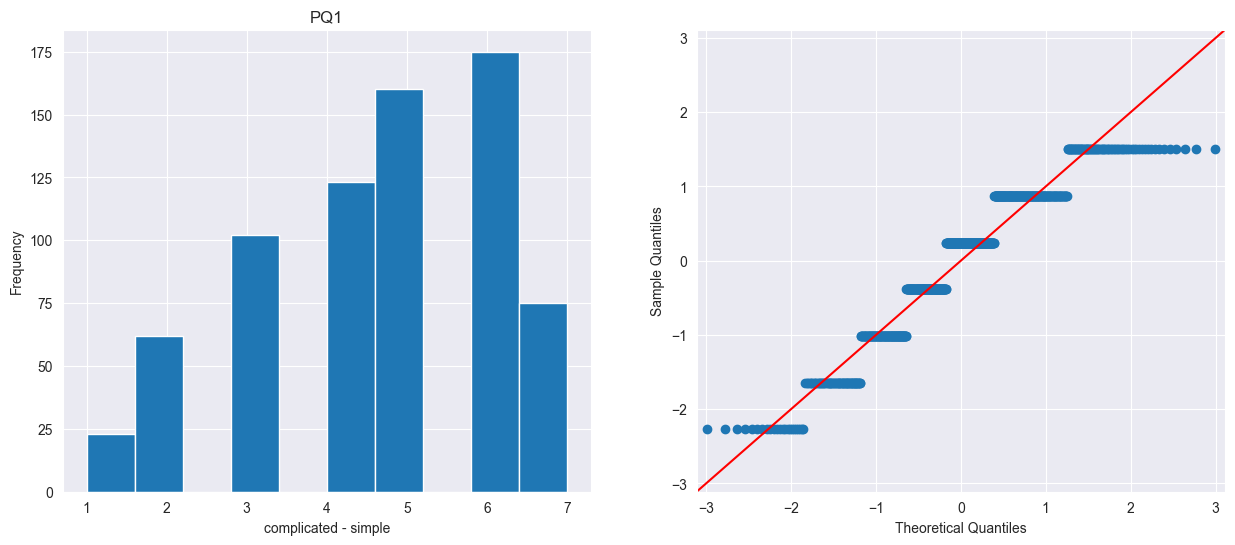

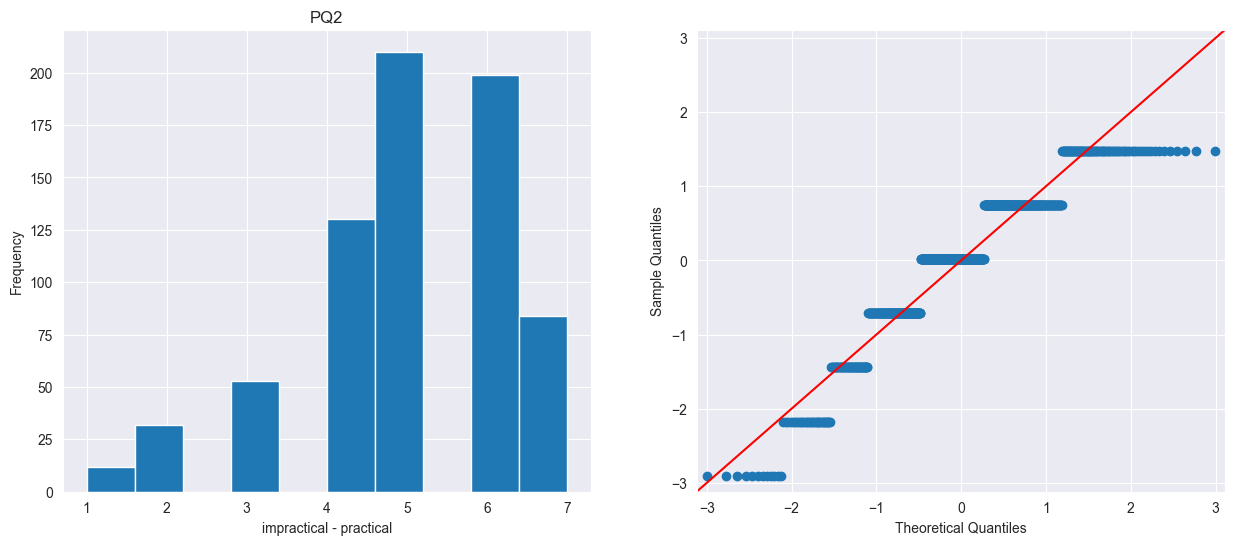

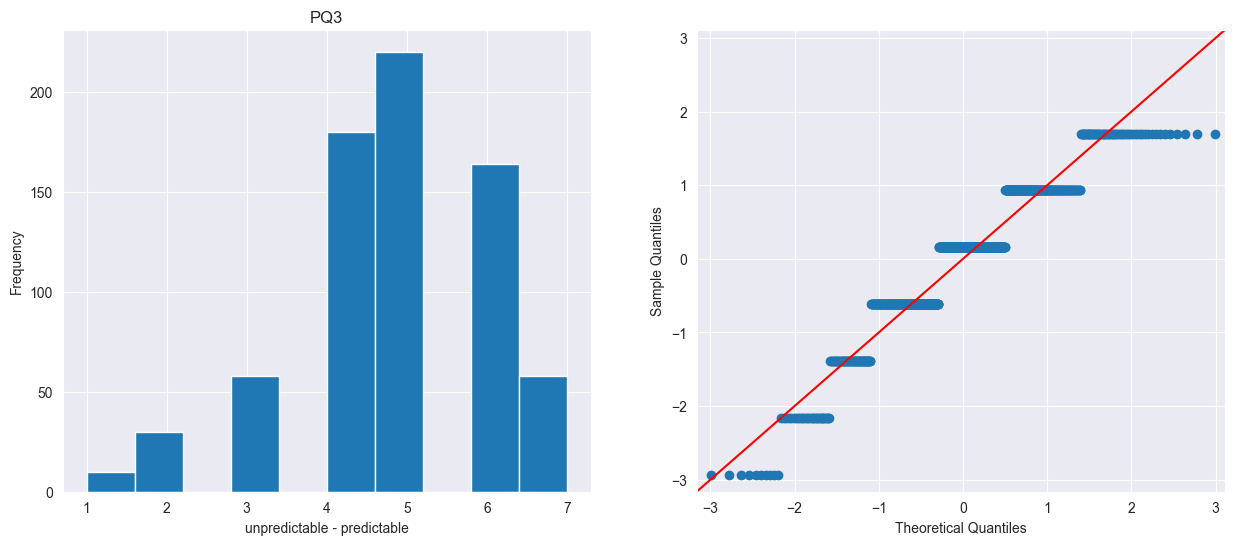

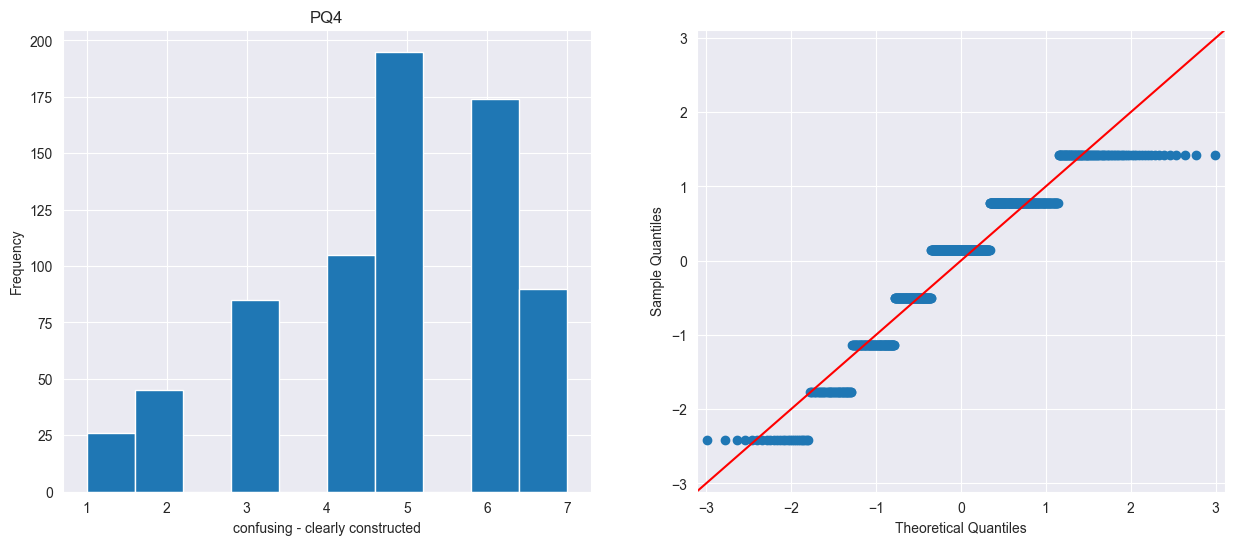

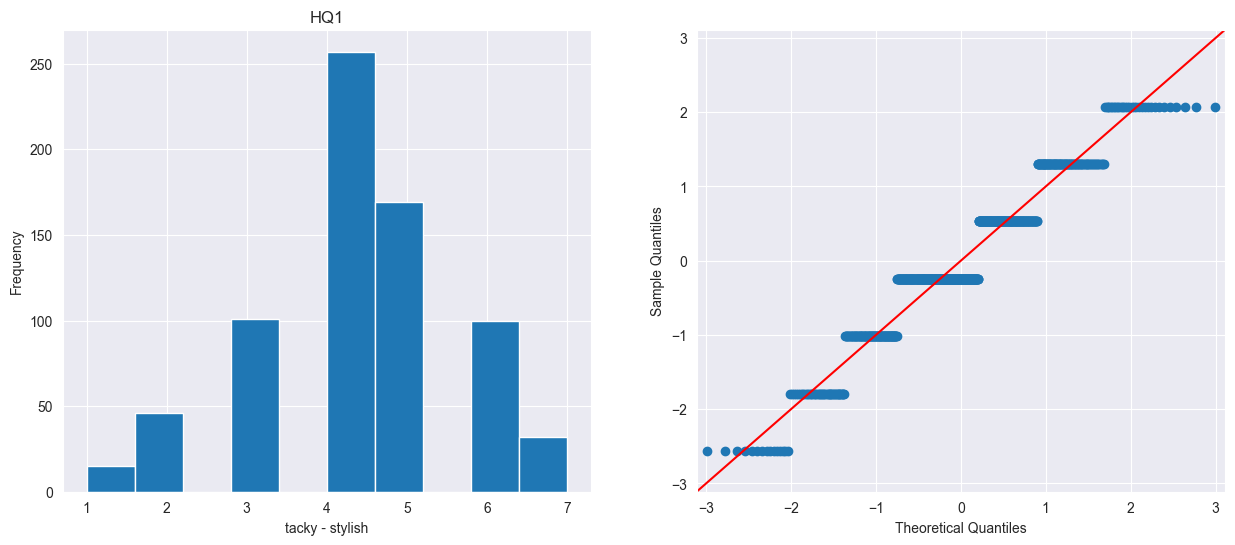

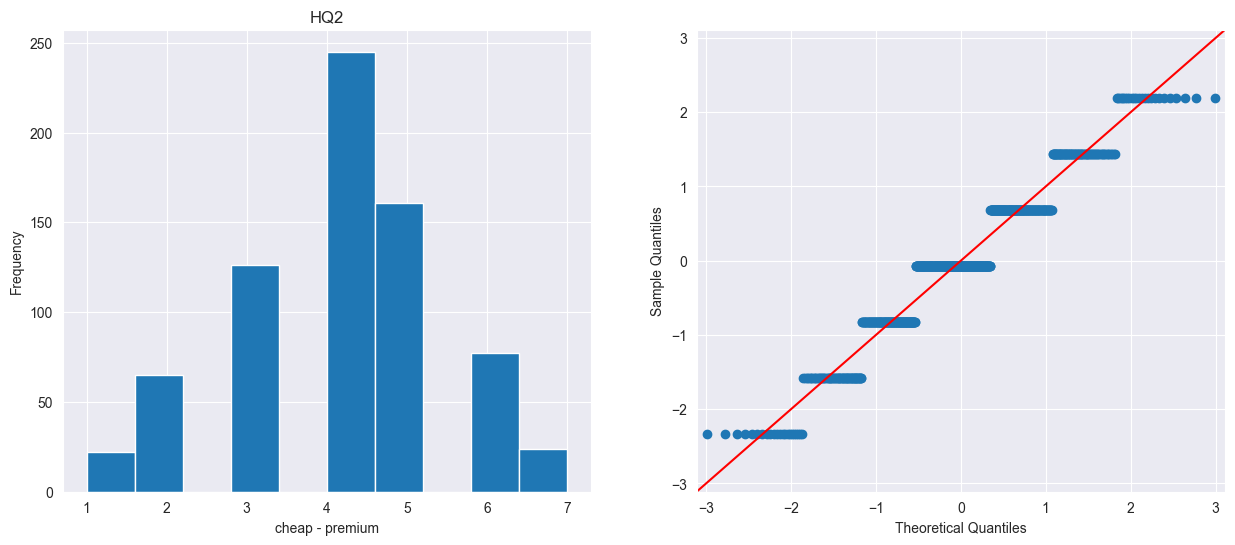

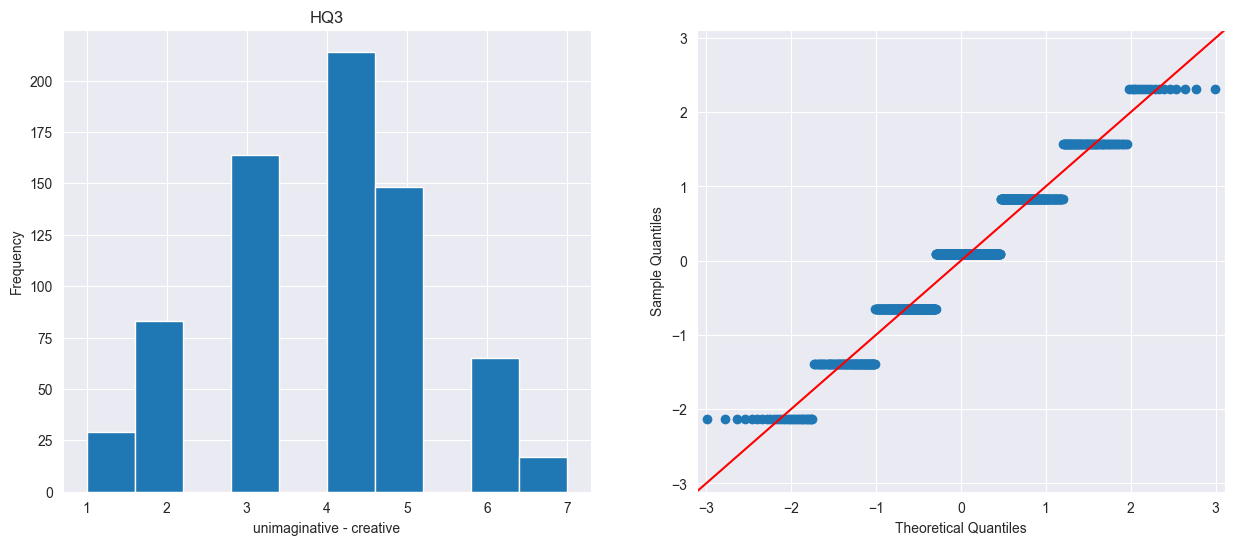

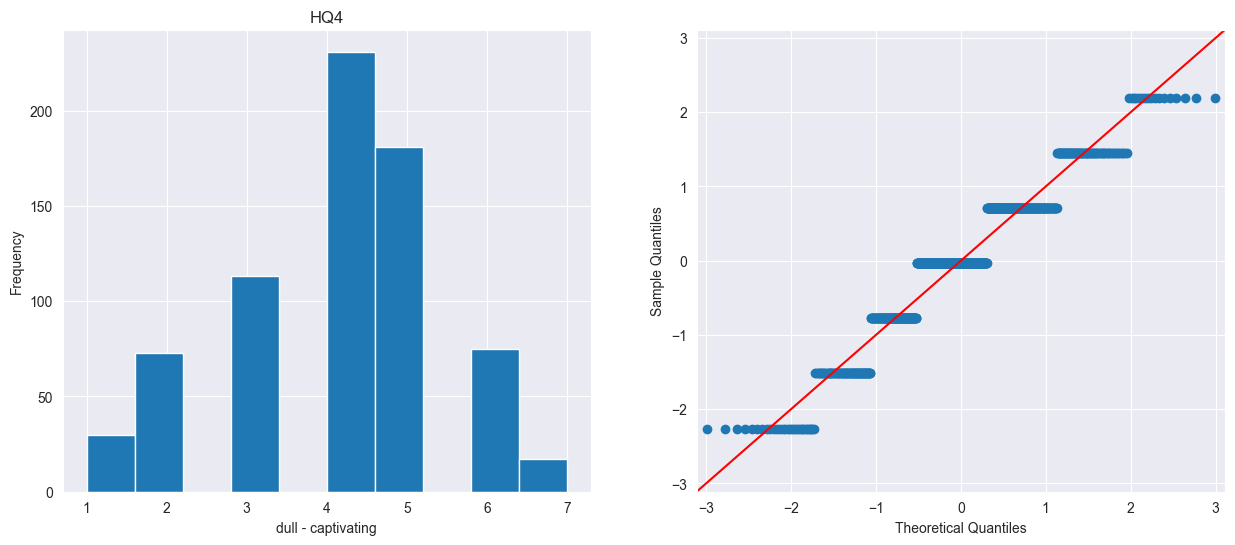

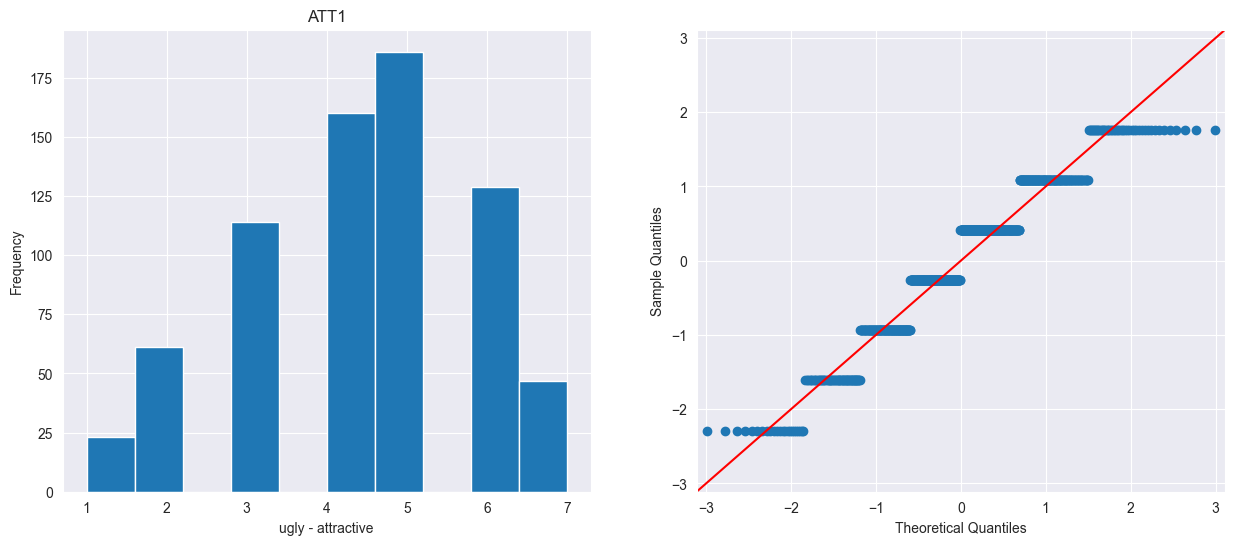

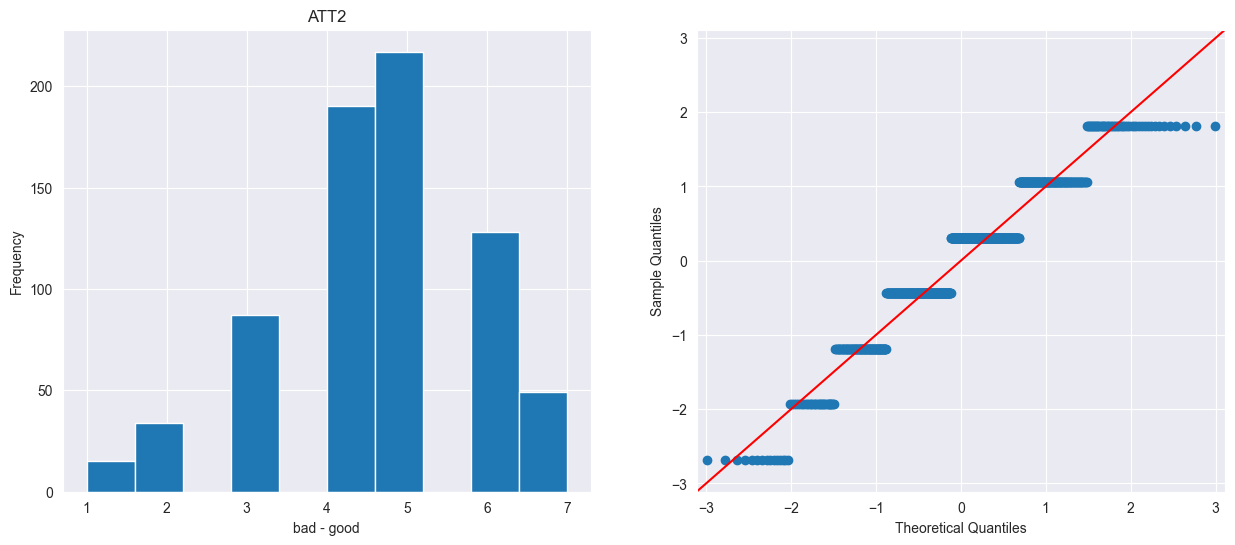

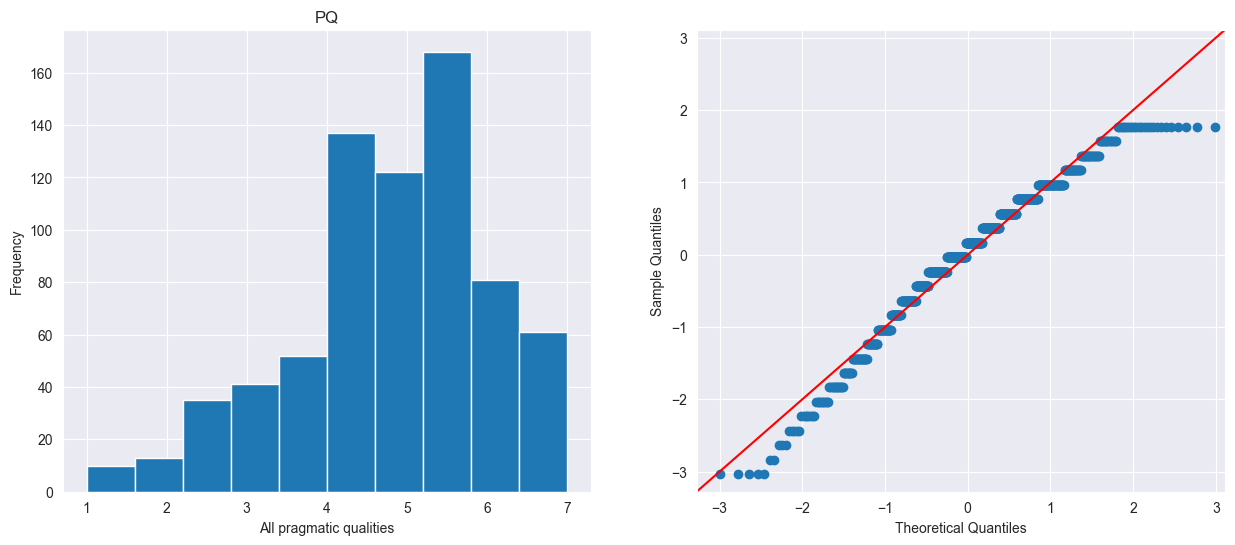

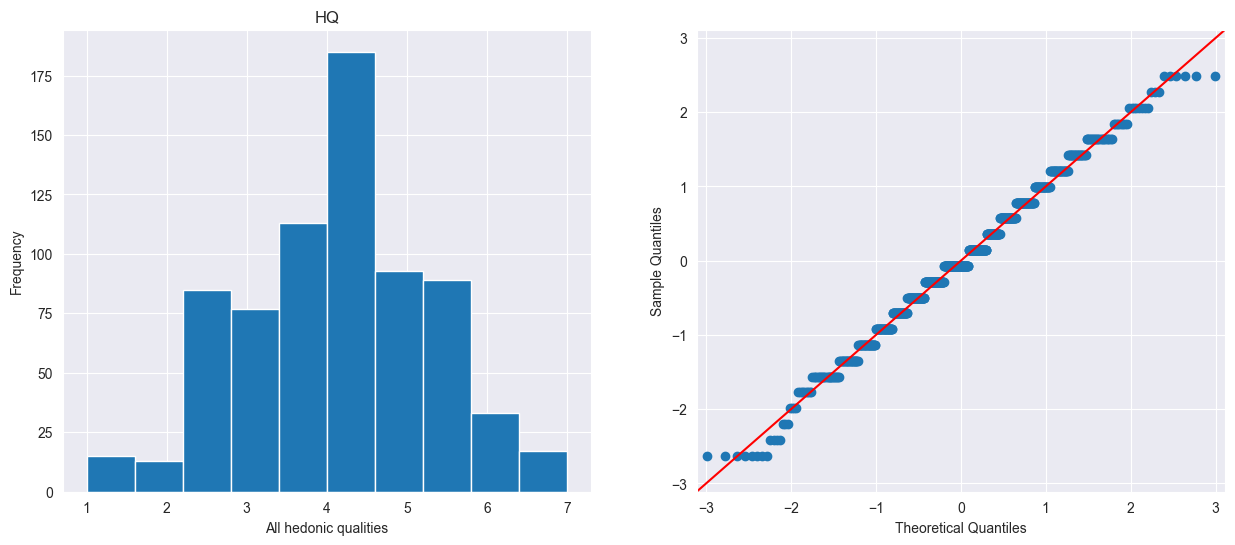

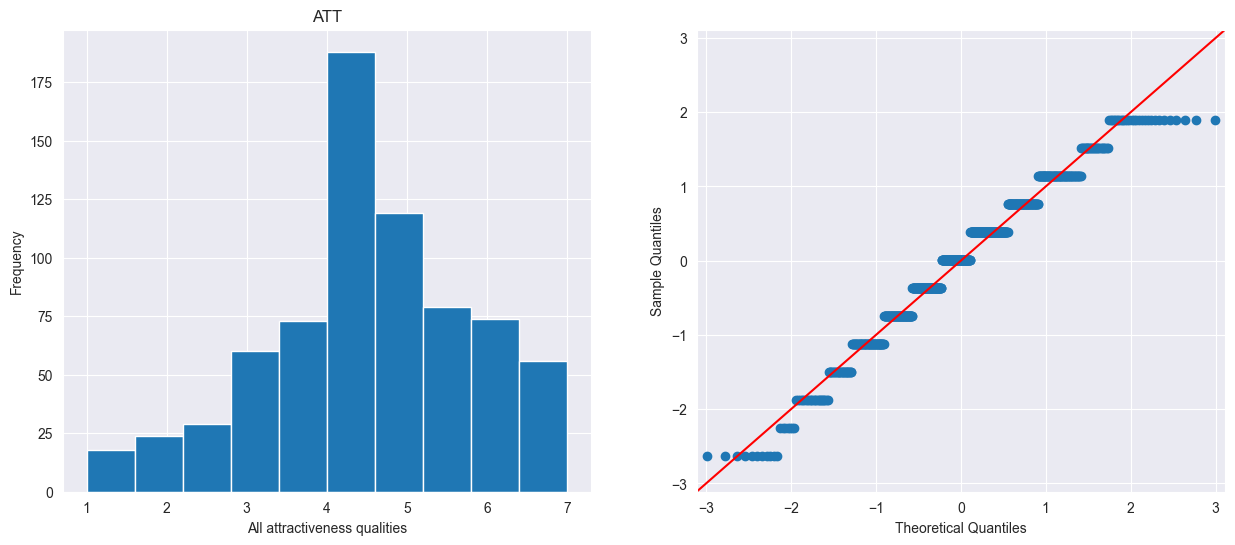

In [9]:
for column in attrak:
    my_hist_with_qq(results, column, column, attrak[column])

In [10]:
for column in ['PQ', 'HQ', 'ATT']:
    print(column)
    print(stats.shapiro(results[column]), end='\n\n')

PQ
ShapiroResult(statistic=0.9714694023132324, pvalue=1.2288142725580542e-10)

HQ
ShapiroResult(statistic=0.9921117424964905, pvalue=0.000712934706825763)

ATT
ShapiroResult(statistic=0.9757691621780396, pvalue=1.508984714959638e-09)



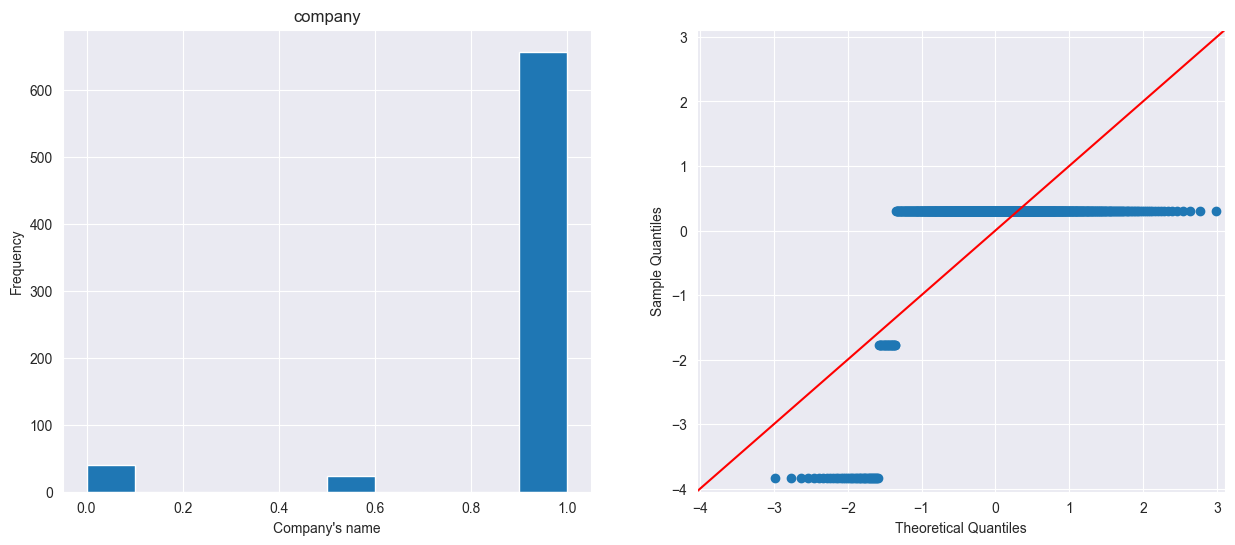

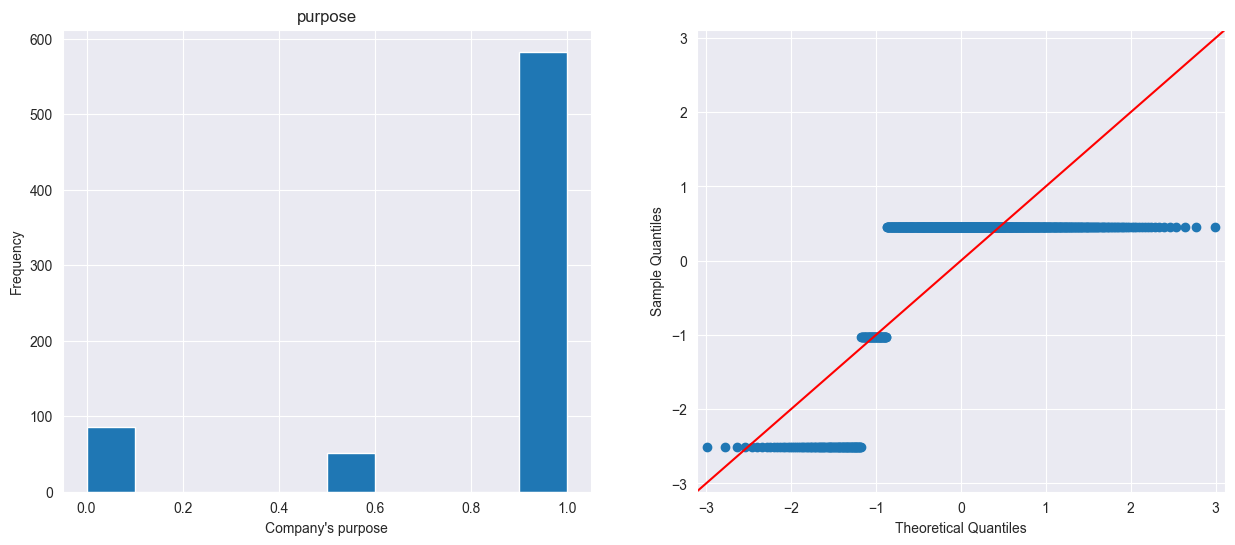

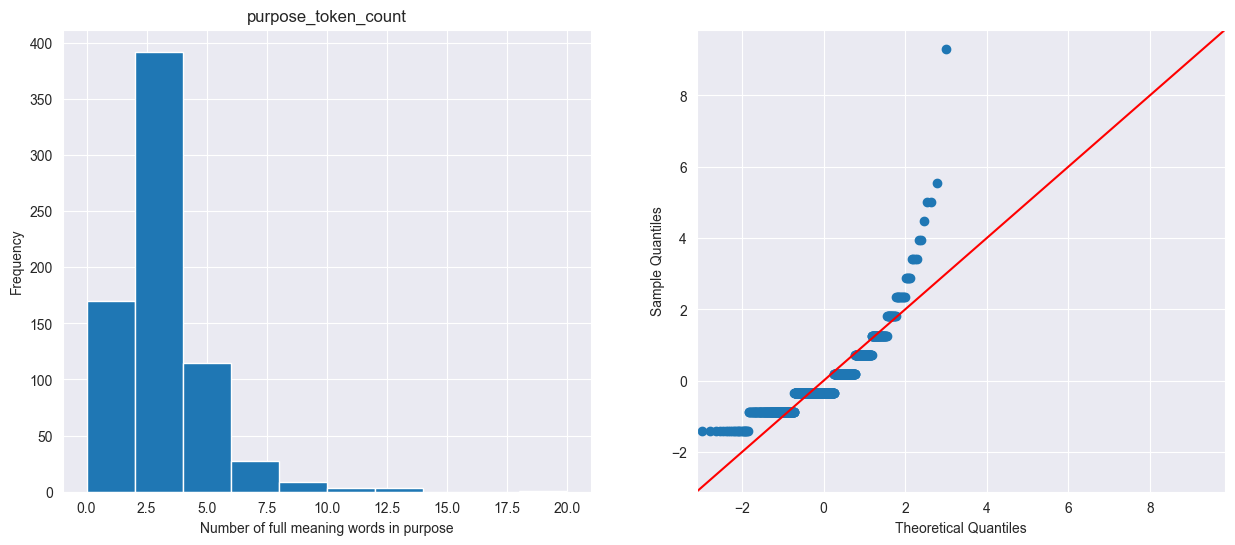

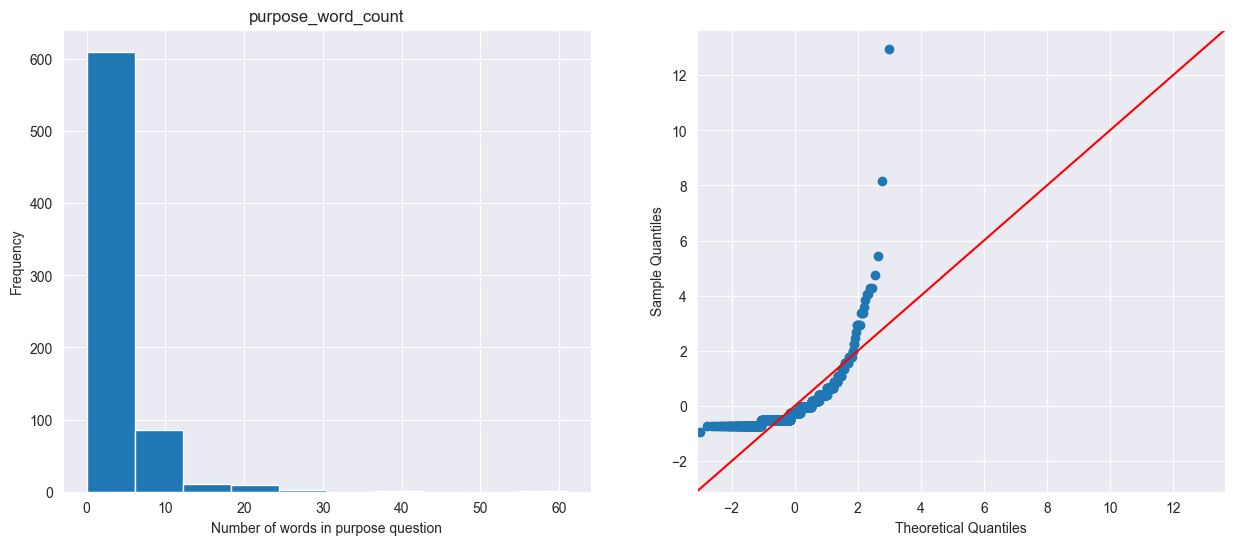

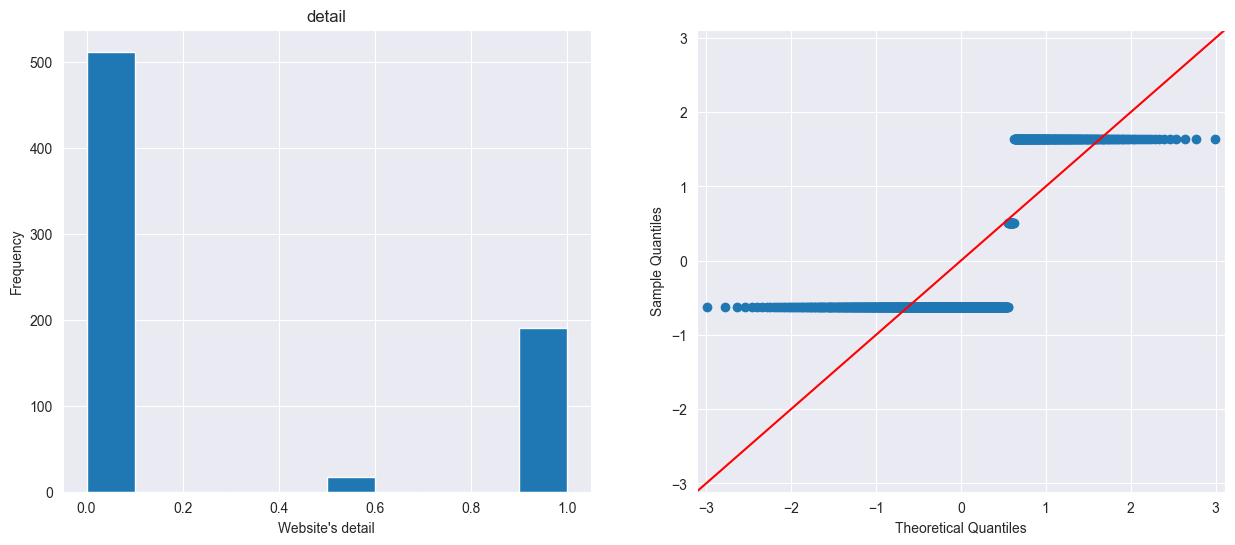

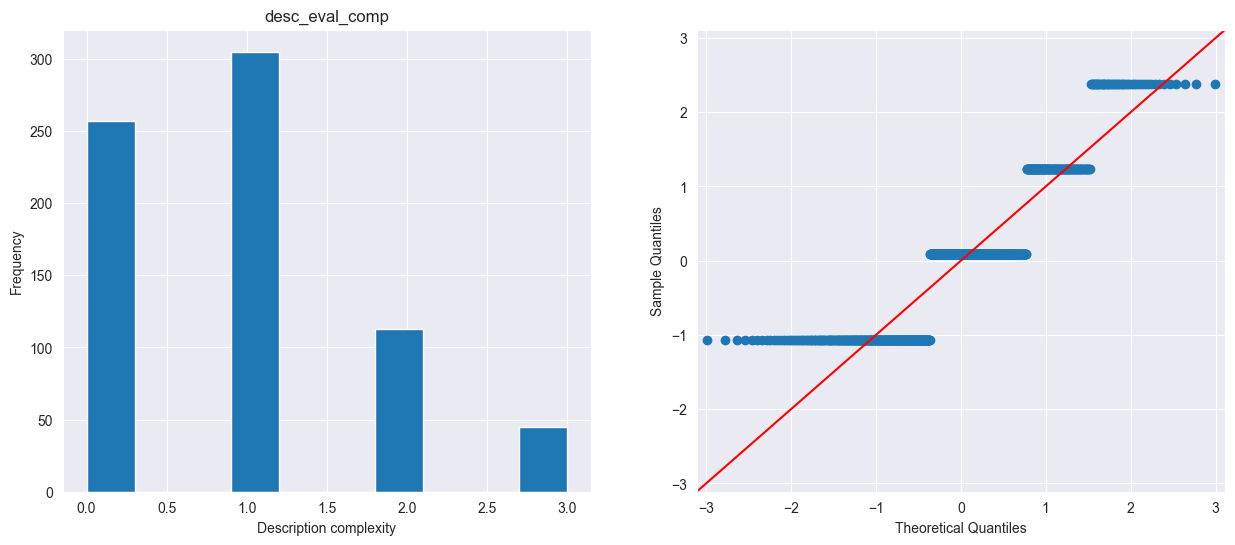

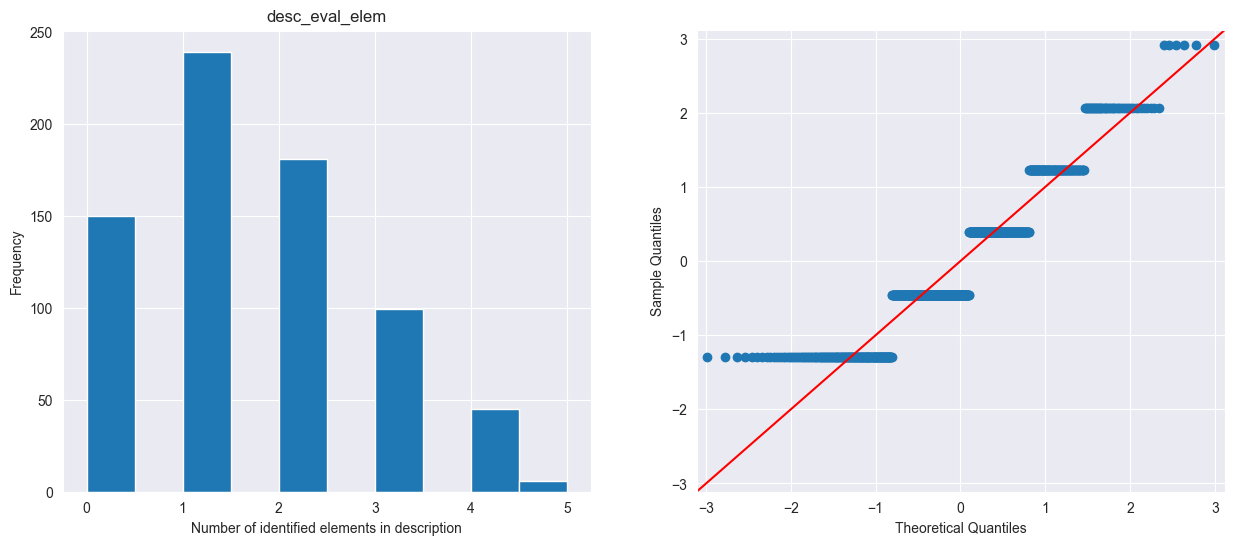

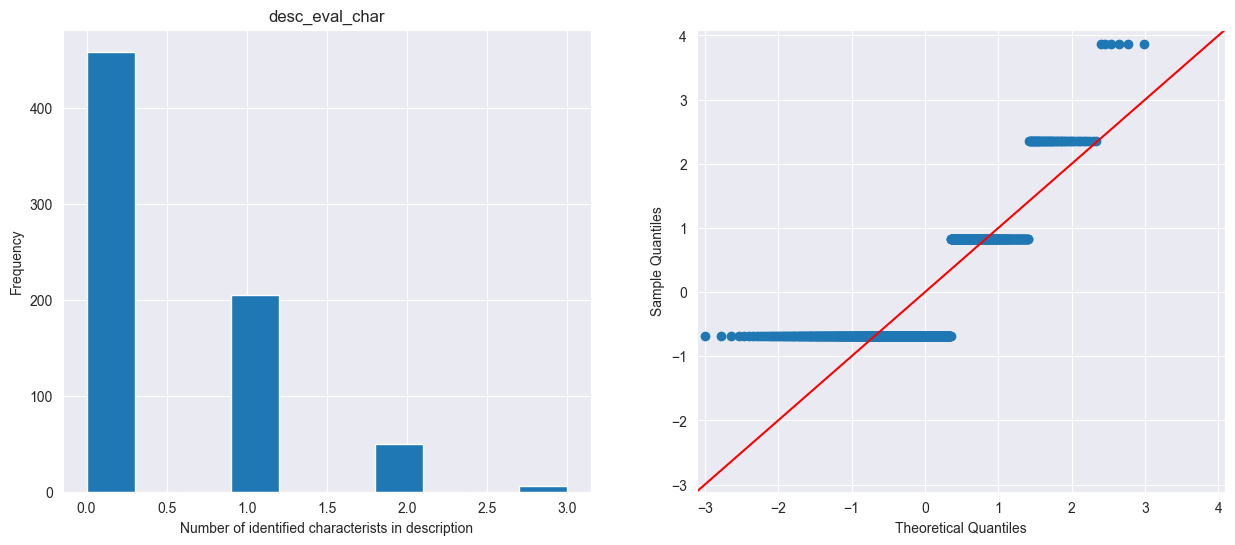

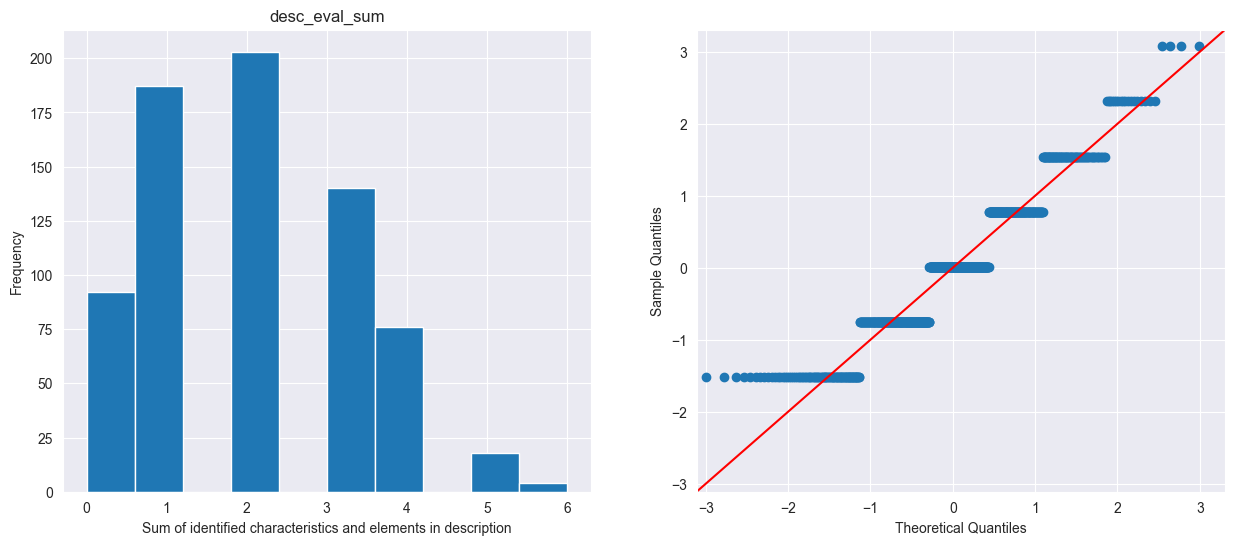

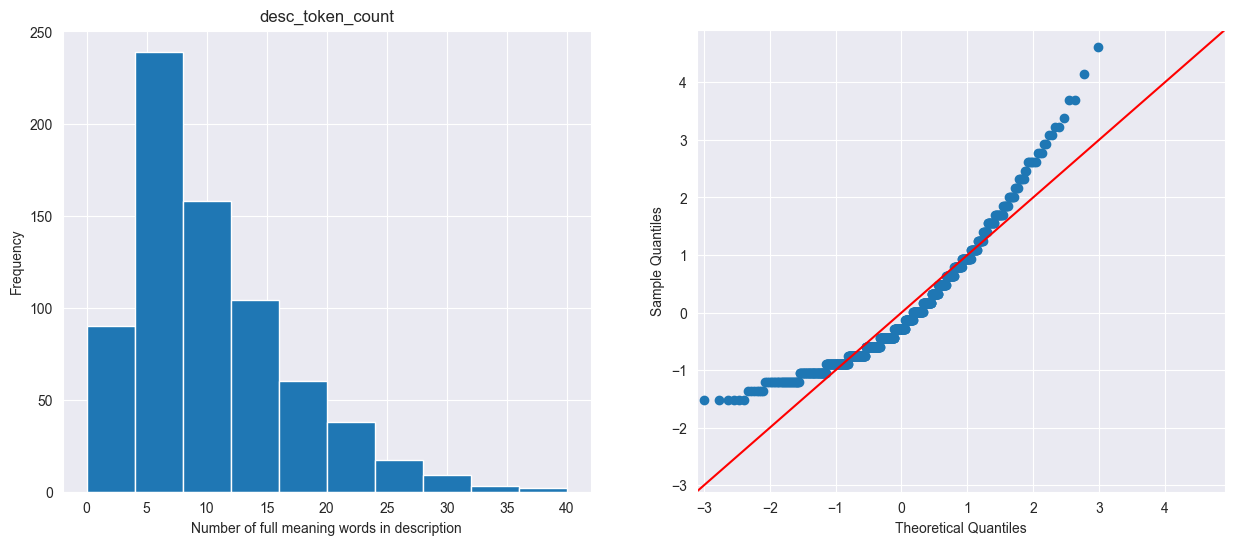

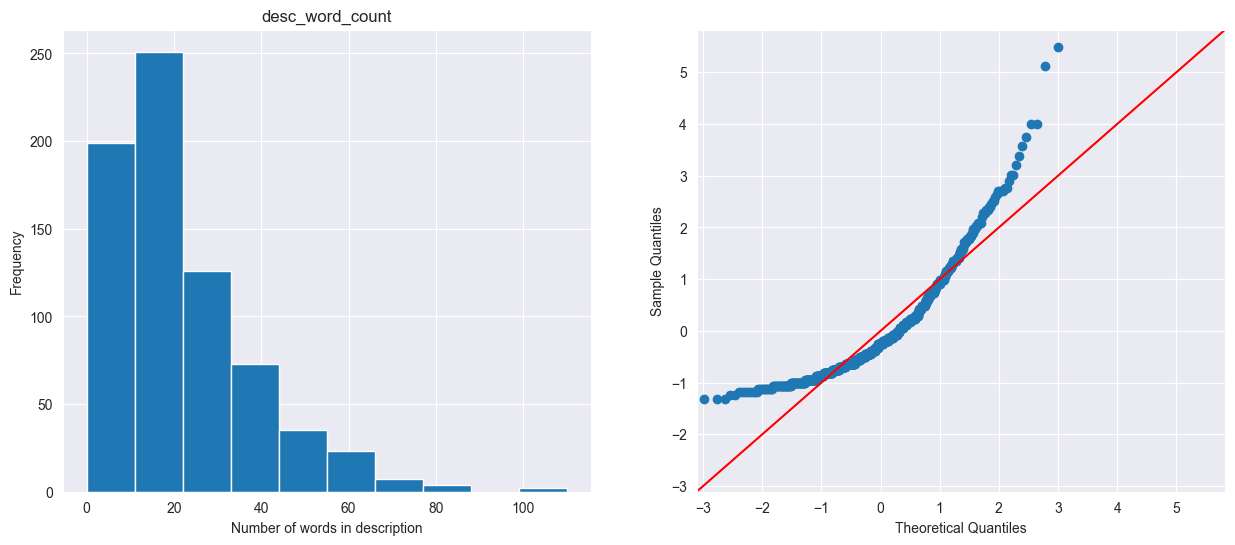

In [11]:
for column in open_text:
    my_hist_with_qq(results, column, column, open_text[column])

In [12]:
for column in open_text:
    print(column)
    print(stats.shapiro(results[column]), end='\n\n')

company
ShapiroResult(statistic=0.31445014476776123, pvalue=1.401298464324817e-45)

purpose
ShapiroResult(statistic=0.4899052381515503, pvalue=4.3325345919994694e-41)

purpose_token_count
ShapiroResult(statistic=0.7854875922203064, pvalue=1.0649690681274651e-29)

purpose_word_count
ShapiroResult(statistic=0.596973180770874, pvalue=8.433401477202289e-38)

detail
ShapiroResult(statistic=0.5761572122573853, pvalue=1.7176001142116005e-38)

desc_eval_comp
ShapiroResult(statistic=0.826347827911377, pvalue=3.25888377745313e-27)

desc_eval_elem
ShapiroResult(statistic=0.900337815284729, pvalue=3.1488057791960576e-21)

desc_eval_char
ShapiroResult(statistic=0.6765130758285522, pvalue=7.352450267482699e-35)

desc_eval_sum
ShapiroResult(statistic=0.9297372698783875, pvalue=7.24895263035538e-18)

desc_token_count
ShapiroResult(statistic=0.9094100594520569, pvalue=2.8004703701168526e-20)

desc_word_count
ShapiroResult(statistic=0.8679254651069641, pvalue=3.647463267218539e-24)



**Boxplots Attrak-Diff.**

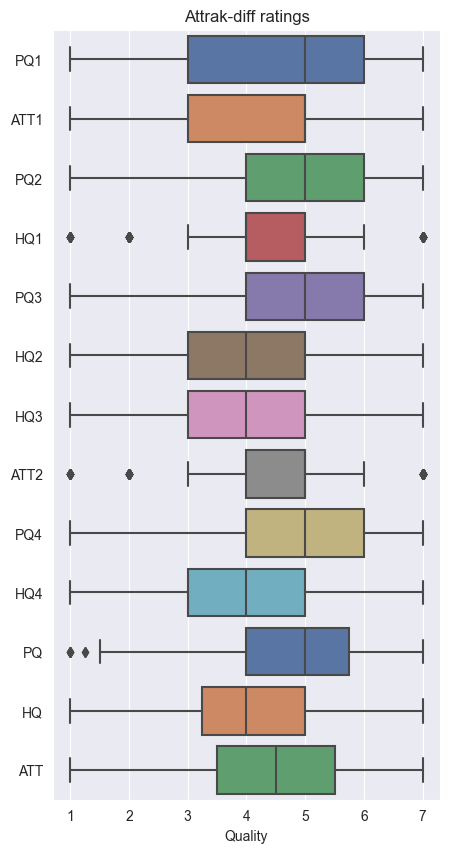

In [13]:
my_box(results, [x for x in results.columns if x in attrak], 'Attrak-diff ratings', 'Quality', None, (5, 10))

**Categorical data**

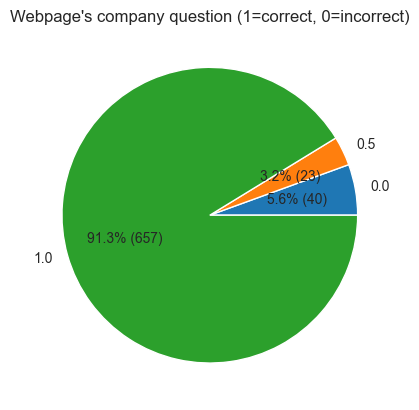

In [14]:
my_pie(results, 'company', 'Webpage\'s company question (1=correct, 0=incorrect)')

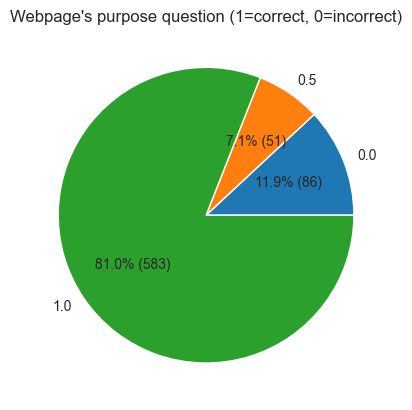

In [15]:
my_pie(results, 'purpose', 'Webpage\'s purpose question (1=correct, 0=incorrect)')

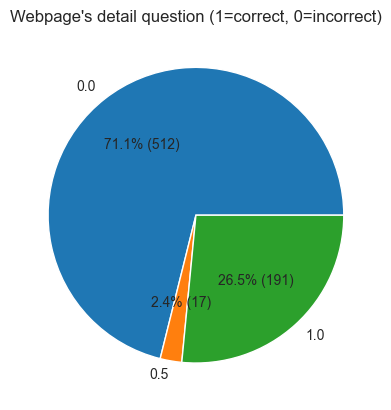

In [16]:
my_pie(results, 'detail', 'Webpage\'s detail question (1=correct, 0=incorrect)')

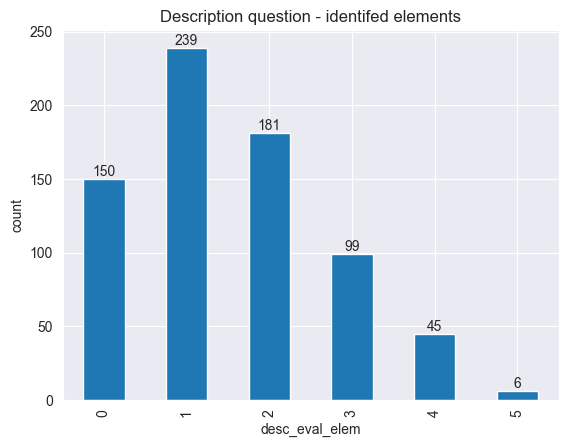

In [17]:
my_bar(results, 'desc_eval_elem', 'Description question - identifed elements')

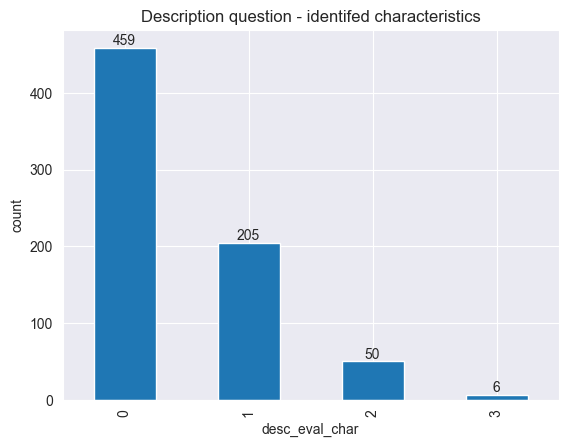

In [18]:
my_bar(results, 'desc_eval_char', 'Description question - identifed characteristics')

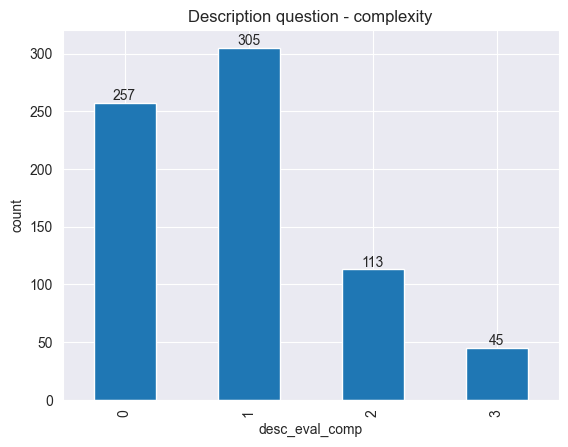

In [19]:
my_bar(results, 'desc_eval_comp', 'Description question - complexity')

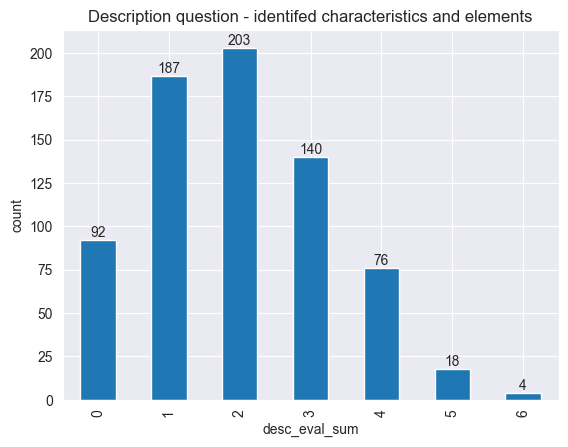

In [20]:
my_bar(results, 'desc_eval_sum', 'Description question - identifed characteristics and elements')

**Word counts.**

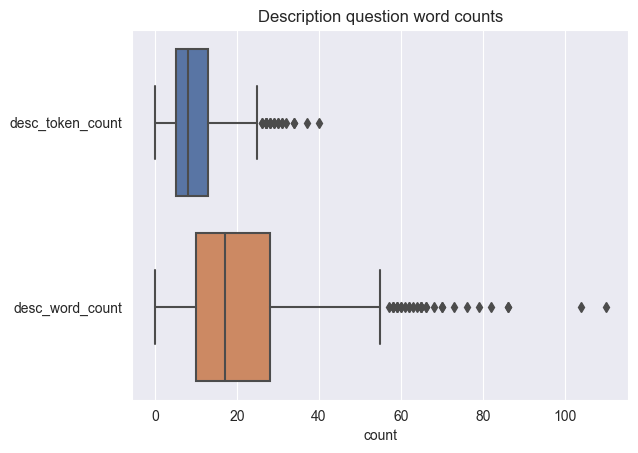

In [21]:
my_box(results, ['desc_token_count', 'desc_word_count'], 'Description question word counts')

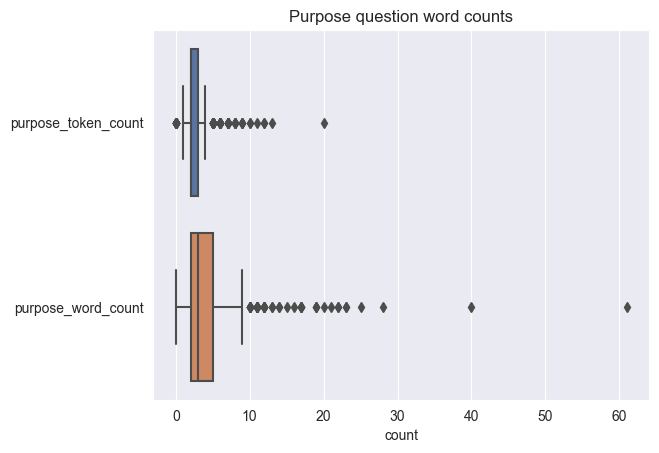

In [22]:
my_box(results, ['purpose_token_count', 'purpose_word_count'], 'Purpose question word counts')

**Time per task**

In [23]:
results.time.mean()

135.41023611111112

In [24]:
results.groupby(['task']).time.mean()

task
1    128.441667
2    130.616667
3    148.341667
4    122.725000
5    137.811417
6    144.525000
Name: time, dtype: float64

**Straightlining detection.**

In [25]:
print('Detected straightlining:\n')
for index, row in results.iterrows():
    if(np.std(row[attrak.keys()]) < 0.3):
        print('Respondent ' + str(row.respondent) + ', task ' + str(row.task) + ', ' + row.interval + ' condition.  STD = ' + str(np.std(row[attrak.keys()])))

Detected straightlining:

Respondent 10, task 6, 2s condition.  STD = 0.2692307692307693
Respondent 13, task 1, 2s condition.  STD = 0.0
Respondent 13, task 2, 2s condition.  STD = 0.28781979898261084
Respondent 13, task 4, 2s condition.  STD = 0.0
Respondent 13, task 5, 2s condition.  STD = 0.0
Respondent 13, task 6, 2s condition.  STD = 0.0
Respondent 22, task 2, 2s condition.  STD = 0.2692307692307693
Respondent 26, task 1, 2s condition.  STD = 0.0
Respondent 26, task 2, 2s condition.  STD = 0.0
Respondent 26, task 3, 2s condition.  STD = 0.0
Respondent 26, task 4, 2s condition.  STD = 0.0
Respondent 26, task 5, 2s condition.  STD = 0.0
Respondent 26, task 6, 2s condition.  STD = 0.0
Respondent 34, task 3, 2s condition.  STD = 0.0
Respondent 38, task 5, 2s condition.  STD = 0.0
Respondent 38, task 6, 2s condition.  STD = 0.0
Respondent 47, task 5, 2s condition.  STD = 0.0
Respondent 9, task 2, 5s condition.  STD = 0.2692307692307693
Respondent 9, task 3, 5s condition.  STD = 0.26923

## Word clouds

task 1 (description)


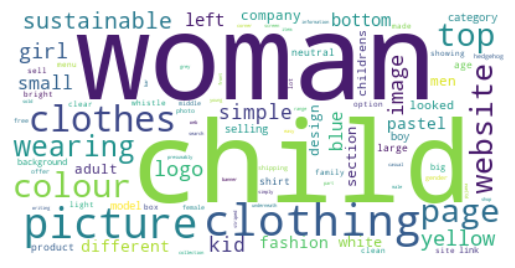

task 2 (description)


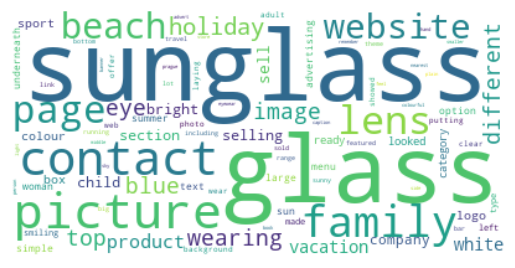

task 3 (description)


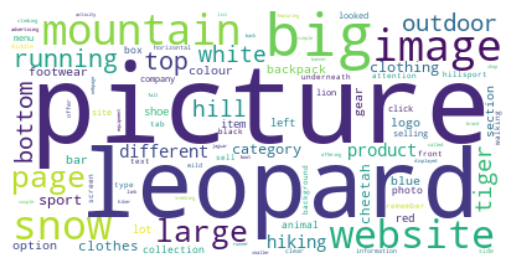

task 4 (description)


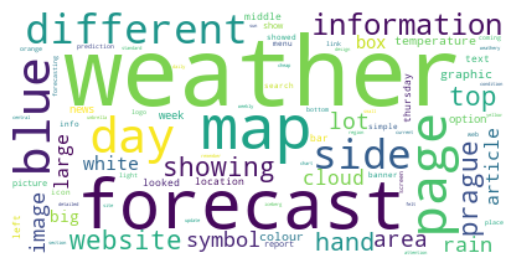

task 5 (description)


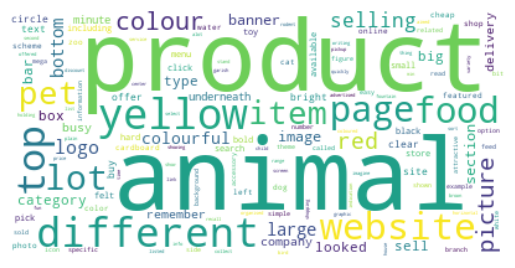

task 6 (description)


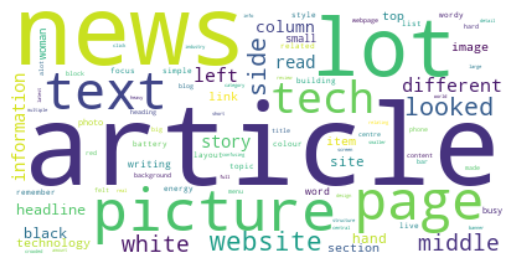

task 1 (purpose)


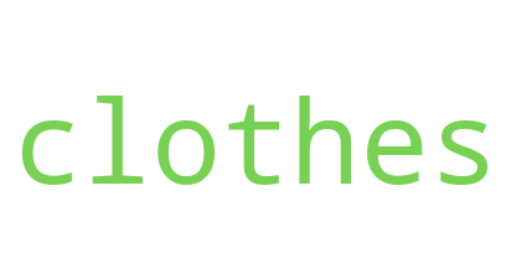

task 2 (purpose)


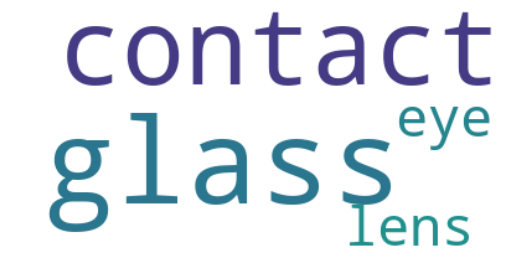

task 3 (purpose)


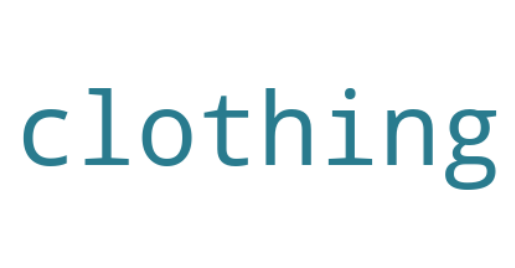

task 4 (purpose)


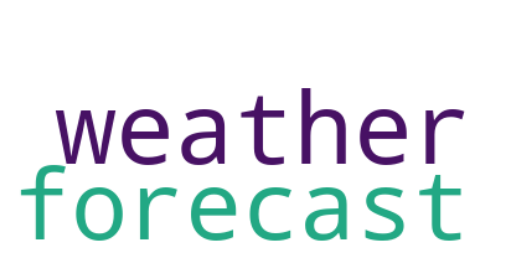

task 5 (purpose)


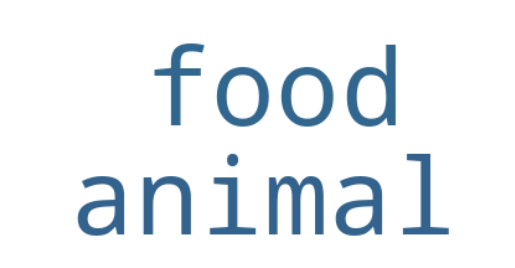

task 6 (purpose)


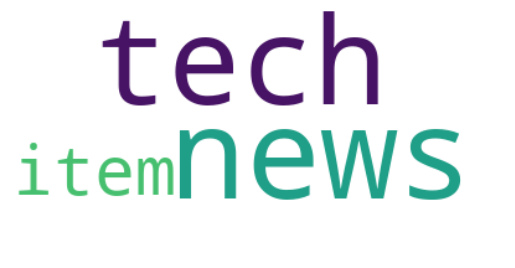

In [26]:
tasks = {1:'',2:'',3:'',4:'',5:'',6:''}

for index, row in results.iterrows():
    tasks[row.task] += (row.desc_tokens + ' ') if type(row.desc_tokens) == str else ''

for task in tasks: 
    print('task ' + str(task) + ' (description)')
    plt.imshow(WordCloud(collocations = False, background_color = 'white').generate(tasks[task]), interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
for index, row in results.iterrows():
    tasks[row.task] = ''
    tasks[row.task] += (row.purpose_tokens + ' ') if type(row.purpose_tokens) == str else ''

for task in tasks: 
    print('task ' + str(task) + ' (purpose)')
    plt.imshow(WordCloud(collocations = False, background_color = 'white').generate(tasks[task]), interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Questionnaire reliability

In [27]:
cronbach_alpha(results[['PQ1', 'PQ2', 'PQ3', 'PQ4']])

(0.8763749796049317, array([0.861, 0.89 ]))

In [28]:
cronbach_alpha(results[['HQ1', 'HQ2', 'HQ3', 'HQ4']])

(0.9059048714153446, array([0.894, 0.917]))

In [29]:
cronbach_alpha(results[['ATT1', 'ATT2']])

(0.8624197356517129, array([0.841, 0.881]))

## Question order effect

In [30]:
results_2s = pd.read_csv("../data/raw_data/5ST case study - 2 seconds - Raw results.csv")
results_5s = pd.read_csv("../data/raw_data/5ST case study - 5 seconds - Raw results.csv")
results_10s = pd.read_csv("../data/raw_data/5ST case study - 10 seconds - Raw results.csv")

In [31]:
results_2s['interval'] = '2s'
results_5s['interval'] = '5s'
results_10s['interval'] = '10s'
results_2s = results_2s[(results_2s['respondent number'] != 40) | (results_2s.interval != '2s')]

In [32]:
orders = pd.concat([
    results_2s[['respondent number', 'task number', 'interval']],
    results_5s[['respondent number', 'task number', 'interval']],
    results_10s[['respondent number', 'task number', 'interval']]
], ignore_index=True)

In [33]:
results_2s[results_2s.index % 7 == 0]['T1Q1: What is the company’s name?']

0          Shoes Design
7          I don't know
14            fair shop
21        Cant remember
28           Don't know
35            fairstart
42          dont rember
49                  NaN
56            Fair Shop
63                  ABC
70           don't know
77              no idea
84              No idea
91         Did not see.
98             Fairshop
105           dont know
112           firstshop
119             no idea
126           lets walk
133             no idea
140         i dont know
147               Shoes
154              Shoes?
161          Fair Group
168                 NaN
175             No idea
182              Unsure
189            Shoes co
196           Fair Shop
203             no idea
210    Shoes collection
217                   ?
224           christmas
238       cant remember
245             no idea
252            not sure
259       I don't know.
266           Fair Shop
273     not sure. TESCO
280           Fair Shop
Name: T1Q1: What is the company’s name?,

In [34]:
results_5s[results_5s.index % 7 == 0]['T1Q1: What is the company’s name?']

0                                     fire shop
7                                   dont recall
14                                     unknown 
21                                    fair shop
28                                     Not sure
35                                    fair shop
42                                    Fair shop
49                                   Don't know
56            fair shop - but I can't remember 
63                                   Don't know
70                                      company
77                                   Don't know
84                                 fair company
91                                    Fair Shop
98                                    Fair Shop
105                                   Dont know
112                                        Fair
119                                  don't know
126                              Didn't get it!
133                                    not sure
140                               Didn't

In [35]:
results_10s[results_10s.index % 7 == 0]['T1Q1: What is the company’s name?']

0                    Fair shop
7                     goodfood
14                I don't know
21           Your shoe company
28                   Fair shop
35                   Fair Shop
42                  Fair Point
49            i dont remember 
56                        Free
63                   Fair shop
70                   Fair Shop
77         I didnt notice that
84                   Fair shop
91                   Dont know
98                   Fairright
105                 Don’t know
112               Sole support
119                  Fair Shop
126                  Fair shop
133             I don't recall
140                  Fair shop
147              Dont remember
154                   Fairshop
161                       Pass
168              cant remember
175                 First Sole
182                  Fair Shop
189                     Unsure
196                      shoes
203                  fair shop
210             Can't remember
217                   Fairshop
224     

In [36]:
x = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6])
for index, row in results.groupby(['interval','respondent']).mean(numeric_only=True).iterrows():
    resp_order = list(map(lambda x: x -1, orders[(orders['respondent number'] == index[1]) & (orders['interval'] == index[0]) & (orders['task number'] != 1)]['task number'].values))
    x.loc[len(x.index)] = [
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[0])]['company'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[1])]['company'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[2])]['company'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[3])]['company'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[4])]['company'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[5])]['company'].values[0],
    ]
for i in [1, 2, 3, 4, 5, 6]:
    print('company, task ' + str(i))
    print(x[i].value_counts())

company, task 1
1.0    111
0.5      5
0.0      4
Name: 1, dtype: int64
company, task 2
1.0    107
0.0     11
0.5      2
Name: 2, dtype: int64
company, task 3
1.0    110
0.0      5
0.5      5
Name: 3, dtype: int64
company, task 4
1.0    110
0.5      5
0.0      5
Name: 4, dtype: int64
company, task 5
1.0    109
0.0      8
0.5      3
Name: 5, dtype: int64
company, task 6
1.0    110
0.0      7
0.5      3
Name: 6, dtype: int64


In [37]:
x = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6])
for index, row in results.groupby(['interval','respondent']).mean(numeric_only=True).iterrows():
    resp_order = list(map(lambda x: x -1, orders[(orders['respondent number'] == index[1]) & (orders['interval'] == index[0]) & (orders['task number'] != 1)]['task number'].values))
    x.loc[len(x.index)] = [
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[0])]['purpose'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[1])]['purpose'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[2])]['purpose'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[3])]['purpose'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[4])]['purpose'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[5])]['purpose'].values[0],
    ]
for i in [1, 2, 3, 4, 5, 6]:
    print('purpose, task ' + str(i))
    print(x[i].value_counts())

purpose, task 1
1.0    96
0.0    17
0.5     7
Name: 1, dtype: int64
purpose, task 2
1.0    96
0.0    17
0.5     7
Name: 2, dtype: int64
purpose, task 3
1.0    99
0.5    11
0.0    10
Name: 3, dtype: int64
purpose, task 4
1.0    97
0.0    13
0.5    10
Name: 4, dtype: int64
purpose, task 5
1.0    100
0.0     14
0.5      6
Name: 5, dtype: int64
purpose, task 6
1.0    95
0.0    15
0.5    10
Name: 6, dtype: int64


In [38]:
x = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6])
for index, row in results.groupby(['interval','respondent']).mean(numeric_only=True).iterrows():
    resp_order = list(map(lambda x: x -1, orders[(orders['respondent number'] == index[1]) & (orders['interval'] == index[0]) & (orders['task number'] != 1)]['task number'].values))
    x.loc[len(x.index)] = [
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[0])]['detail'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[1])]['detail'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[2])]['detail'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[3])]['detail'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[4])]['detail'].values[0],
        results[(results.interval == index[0]) & (results.respondent == index[1]) & (results.task == resp_order[5])]['detail'].values[0],
    ]
for i in [1, 2, 3, 4, 5, 6]:
    print('detail, task ' + str(i))
    print(x[i].value_counts())

detail, task 1
0.0    83
1.0    31
0.5     6
Name: 1, dtype: int64
detail, task 2
0.0    90
1.0    30
Name: 2, dtype: int64
detail, task 3
0.0    84
1.0    34
0.5     2
Name: 3, dtype: int64
detail, task 4
0.0    82
1.0    36
0.5     2
Name: 4, dtype: int64
detail, task 5
0.0    84
1.0    31
0.5     5
Name: 5, dtype: int64
detail, task 6
0.0    89
1.0    29
0.5     2
Name: 6, dtype: int64


### Familiarity

In [39]:
results[results.familiarity == True]

,respondent,task,complexity,interval,time,company,purpose,purpose_tokens,purpose_token_count,purpose_word_count,...,PQ3,HQ2,HQ3,ATT2,PQ4,HQ4,PQ,HQ,ATT,familiarity
30,9,1,0.22,2s,98.0,1.0,1.0,clothing,1,1,...,5,5,4,5,5,4,5.00,4.50,5.0,True
33,9,4,5.27,2s,97.0,1.0,1.0,weather forecast,2,2,...,6,2,2,4,4,3,4.50,2.50,3.5,True
210,42,1,0.22,2s,93.0,1.0,1.0,sustainable clothing,2,2,...,6,4,3,5,6,3,5.75,3.75,4.5,True
242,50,3,2.97,2s,140.0,1.0,1.0,outdoor clothing equipment believe,4,6,...,5,5,6,6,7,6,5.75,6.00,6.0,True
420,37,1,0.22,5s,235.0,1.0,1.0,clothes woman child,3,6,...,7,6,4,5,6,4,6.50,4.75,6.0,True
435,40,4,5.27,5s,204.0,1.0,1.0,believe website detailed global weather forcas...,10,17,...,7,6,5,6,5,5,5.50,5.25,5.5,True
489,2,4,5.27,10s,244.0,1.0,1.0,weather forecast,2,2,...,5,4,4,5,3,4,4.25,4.00,4.5,True
516,9,1,0.22,10s,174.0,1.0,1.0,clothes woman child,3,6,...,5,7,5,6,6,5,5.75,5.75,6.0,True
589,22,2,2.00,10s,59.0,1.0,1.0,eyewar sunglass,2,3,...,4,3,4,4,3,3,4.00,3.25,4.5,True
630,30,1,0.22,10s,72.0,1.0,1.0,clothing,1,1,...,5,5,5,6,7,5,6.00,5.25,6.0,True
